# Functions

In [1]:
using CSV
using Tables
using DataFrames
using Statistics
using LinearAlgebra
using Plots
using Optim
using NearestNeighbors
plotlyjs()


Plots.PlotlyJSBackend()

In [2]:
include("C:/Users/mjbarillas/Documents/GitHub/Mimosa/scripts/MB Ex/PB_10S/ex1_stat_EM_PB_10S.jl")

run (generic function with 2 methods)

In [3]:
function ReadData_i(S,conf,pot)
    Λ = pot/5000
    Λstring = replace(string(round(Λ, digits=2)), "." => "_")
    diffstrat = "autodiff"
    problemName = "PB-S$S-O2-/$diffstrat/Yeoh/PL"
    for s in conf
        problemName = problemName*"_$s"
    end
    pot_10 = 10*pot
    problemName = problemName*"_ϕ$pot_10"
    file_name = "data/csv/" * problemName * "/_Λ_" * Λstring * ".csv"
    _X = CSV.File(file_name) |> Tables.matrix
    x = _X[:,1]
    return x
end

ReadData_i (generic function with 1 method)

In [4]:
function isomap1(neighbors,Z_)
    n = length(eachcol(Z_))
    D_G = [[] for i in 1:n]
    # count = []
    # count2 = []
    list = [1:n...]
    Threads.@threads for i in 1:n
        d_G, prev_ = Dijkstra(Z_,i,neighbors)
        D_G[i] = d_G
        deleteat!(list, findall(x->x==i,list))
        print("\r$((100-round(length(list)/n,digits=2)*100)) %             ")
    end
    print("\n")
    D_G = reduce(hcat,D_G)
    D_G_sym = 0.5*(D_G+D_G')
    D_G_sq = D_G_sym.^2
    C = I - (1/n)*ones(n,n)
    B = -0.5*C*D_G_sq*C
    f(λ) = -real(λ)
    _iso = eigen(B, sortby=f)
    Λ_iso = real.(_iso.values)
    U_iso = real.(_iso.vectors)
    Λ_iso_m = diagm(sqrt.(Λ_iso[[1,2]]))
    U_iso_m = U_iso[:,[1,2]]
    X_iso = U_iso_m*Λ_iso_m
    return X_iso', D_G_sym
end

function Dijkstra(data,i,nieghbors)
    m, n = size(data)
    dist = [Inf64 for i in 1:n]
    prev = [0 for i in 1:n]
    nodes = data
    kdtree = KDTree(nodes; leafsize = 10)
    dist[i] = 0
    visited = []
    dist_ = copy(dist)
    while length(visited)<n
        # println(length(visited))
        u = argmin(dist_)
        append!(visited,u)
        distu = dist[u]
        idxs, dists = knn(kdtree, data[:,u], nieghbors, true,
        x -> maximum(isequal.(x,visited)))
        for i in 1:lastindex(idxs)
            alt = distu + dists[i]
            if alt<dist[idxs[i]]
                dist[idxs[i]]=alt
                prev[idxs[i]]=u
            end
        end
        dist_ = copy(dist)
        dist_[visited].=Inf64
    end
    return dist, prev
end

function kPOD(Κ,X,k)
    m, n = size(X)
    # X̄ = [1. for i in 1:n]
    # mean!(X̄',X)
    # for i in 1:n
    #     X[:,i] = X[:,i].-X̄[i]
    # end
    G = [Κ(X[:,i],X[:,j]) for i in 1:n, j in 1:n]
    # display(G)
    II = ones(n,n)
    Ḡ = G - (1/n)*G*II - (1/n)*II*G + (1/n^2)*II*G*II 
    # display(Ḡ)
    f(λ)=-abs(λ)
    Λ_ = eigen(Ḡ,sortby=f)
    Λ = Λ_.values
    U = Λ_.vectors
    Σ = diagm(real.(sqrt.(complex(Λ))))
    Σ_ = Σ[:,[1:k...]]
    U_ = U*pinv(Σ_')
    # U_ = U[:,1:k]
    return Λ, U, U_, Ḡ, G
end


kPOD (generic function with 1 method)

In [5]:
function plot_eigen(Λ)
    Λ = real.(Λ)
    Λ_t = sum(Λ)
    Λ = (1/Λ_t)*Λ
    Λ_s = round.(100*Λ[[i for i in 1:10]])
    p = bar(real.(Λ_s),xlabel="λ",ylabel="%", legend=false, hover=real.(Λ_s),
    xticks=collect(1:10),
    ylims=(0,100)
    )
    display(p)
end

plot_eigen (generic function with 1 method)

In [6]:
function VectorSearch(Z_,conf,list)
    n = length(list)
    z = Z_[:,list]
    v = [z[:,i]-Z_[:,1] for i in 1:n]
    z = Z_[:,1]
    for i in 1:Int(lastindex(conf)/2)
        for j in 1:4
            if conf[[(((i-1)*2)+1):(((i-1)*2)+2)...]] == digits(j-1,base=2,pad=2)
                z = z + v[((i-1)*4)+j]
            else
                z = z
            end
        end
    end
    return z
end

VectorSearch (generic function with 1 method)

In [7]:
function ReverseMap(X,Z_,z,d,n)
    w = [1/sqrt(dot(z-zi,z-zi)) for zi in eachcol(Z_)]
    # w = [exp(-sqrt(dot(z-zi,z-zi))) for zi in eachcol(Z_)]
    # display(w)
    w_sort = sortperm(w, rev=true)
    w_ns = [w[w_sort[1]]]
    X_ns = X[:,w_sort[1]]
    Z_ns = Z_[:,w_sort[1]]
    for i in 2:n
        push!(w_ns,w[w_sort[i]])
        X_ns = hcat(X_ns,X[:,w_sort[i]])
        Z_ns = hcat(Z_ns,Z_[:,w_sort[i]])
    end
    # w_ns = w_ns/sum(w_ns)
    w_ns = pinv(Z_ns)*z
    w_ns = w_ns/sum(w_ns)
    x = X_ns*w_ns
    if d
        y = [0.004]
        n = length(x)
        for i in 1:n
            push!(y,y[i]+0.001*real.(x[i]))
        end
        x=y
    end
    return x, w_ns, Z_ns
end

function bin_to_int4(bin)
    num = 0
    for i in 1:4
        if bin == digits(i-1,base=2,pad=2)
            num = i
        end
    end
    return num
end

function ReverseMap2(y_gen,conf_gen,Y_,X,conf,nh,t)
    n = lastindex(eachcol(conf))
    n_ = Int(length(conf_gen)/2)
    x_gen = []
    for j in 1:n_
        param1 = []
        for i in 1:n
            push!(param1,bin_to_int4(conf[[(((j-1)*2)+1):(((j-1)*2)+2)...],i]))
        end
        # println(param1)
        sort_param1 = sortperm(param1)
        group_param = 1
        group = [[] for _ in 1:4]
        count = 1
        for i in 1:n
            if param1[sort_param1[i]]==group_param
                push!(group[count],sort_param1[i])
            else
                count += 1
                group_param += 1
                push!(group[count],sort_param1[i])
            end
        end
        param1_test = bin_to_int4(conf_gen[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
        # param1_test += 1
        y_sec = [((10*(j-1)+1)):((10*j)+1)...]
        l = j + 10
        x_sec = [((10*(l-1)+2)):((10*l)+2)...]
        # if j==10
        #     append!(sec,101)
        # end
        x_gen_j, w_ns, Z_ns = ReverseMap(X[:,group[param1_test]],
        Y_[:,group[param1_test]],y_gen,false,nh)
        push!(x_gen,hcat(x_gen_j[x_sec],x_gen_j[y_sec])')
    end
    for i in 2:10
        Δ = x_gen[i][:,begin]-x_gen[i-1][:,end]
        x_gen[i] = x_gen[i].-Δ
        θ1 = atan((x_gen[i-1][2,end] - x_gen[i-1][2,end-1])/(x_gen[i-1][1,end] - x_gen[i-1][1,end-1]))
        θ2 = atan((x_gen[i][2,begin+1] - x_gen[i][2,begin])/(x_gen[i][1,begin+1] - x_gen[i][1,begin]))
        Δθ = θ1 - θ2
        rot = [cos(Δθ) -sin(Δθ); sin(Δθ) cos(Δθ)]
        x_gen_i = x_gen[i]
        b = x_gen_i[:,1]
        x_gen_i = x_gen_i.- b
        x_gen_i = rot*x_gen_i
        x_gen[i] = x_gen_i
        x_gen[i] .+= b
    end
    for i in 1:lastindex(x_gen)-1
        x_gen[i] = x_gen[i][:,[1:end-1...]]
    end
    x_gen_0_ = reduce(hcat,x_gen)
    x_gen_0 = vcat(x_gen_0_[2,:],x_gen_0_[1,:])
    return x_gen_0
end

ReverseMap2 (generic function with 1 method)

In [8]:
function NewData2(x_test,Κ,neighbors,G,Z_,D_G_sym,Y_)
    Κ_test(X) = Κ(x_test,X)
    g_i = Κ_test.(eachcol(X))
    n = length(g_i)
    ḡ_i = g_i - (1/n)*G*ones(n,1) - (1/n)*ones(n,n)*g_i +
    ((1/n^2)*ones(1,n)*G*ones(n,1))[1]*ones(n,1)
    z_i = real.(U_'*ḡ_i)
    # scatter!(eachrow(z_i)..., hover = [i for i in 1:lastindex(eachcol(Z_))])
    Z_i = hcat(Z_,z_i)
    Last = lastindex(eachcol(Z_i))
    d_G_i, prev_ = Dijkstra(Z_i,Last,neighbors)
    D_G = D_G_sym
    D_G_sq = D_G.^2
    d_G_sq = [(1/n)*sum(D_G_sq[:,i]) for i in 1:n]
    d_G_sq_i = d_G_i.^2
    Y_cent = [(1/n)*sum(Y) for Y in eachrow(Y_)]
    Y_cent_ = reduce(hcat,[Y_cent for i in 1:n])
    Y_ = Y_-Y_cent_
    F = (1/2)*Y_*(d_G_sq-d_G_sq_i[[1:n...]])
    C = Y_*Y_'
    C_inv = inv(C)
    y_new = C_inv*F
    y_new = y_new+Y_cent
    return y_new
end

NewData2 (generic function with 1 method)

# ROM Offline

## Data colection

### New Data

In [9]:
cd("C:/Users/mjbarillas/Documents/GitHub/Mimosa/")
S,conf,pot  = 10,[1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1],5000.0
x_i_ = ReadData_i(S,conf,pot);

In [ ]:
x_i_[[102:201...]]

In [ ]:
plot(x_i_[[102:202...]], x_i_[[1:101...]],
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(conf) @ $pot V",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
# ylims=(-0.01,0.01)
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S__FOS_10011001_5kV.svg")

In [10]:
x_i(conf) = ReadData_i(S,conf,pot)

x_i (generic function with 1 method)

In [11]:
n = 340
C_n = CSV.File("data/csv/Config_PB_10S_40ref_1000rand.csv")|> Tables.matrix
C_n = Int.(C_n[:,[1:n...]])

20×340 Matrix{Int64}:
 0  1  0  1  0  0  0  0  0  0  0  0  0  …  1  0  1  1  0  1  1  0  1  1  1  0
 0  0  1  1  0  0  0  0  0  0  0  0  0     0  1  1  0  0  0  0  0  0  1  1  0
 0  0  0  0  0  1  0  1  0  0  0  0  0     0  0  0  0  0  0  1  0  1  1  1  0
 0  0  0  0  0  0  1  1  0  0  0  0  0     0  0  0  1  1  1  0  1  1  0  1  0
 0  0  0  0  0  0  0  0  0  1  0  1  0     0  0  1  0  1  1  0  1  1  0  0  1
 0  0  0  0  0  0  0  0  0  0  1  1  0  …  0  0  1  0  1  0  0  1  0  1  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  0  1  0  1  1  0  0  0  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  0  1  0  0  1  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  1  0  1  0  1  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  1  0  0  1  0  0  1  0  0  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  1  1  0  0  0  1  1  1
 0  0  0  0  0  0  0  0  0  0  0  0  0    

In [12]:
X = x_i.(eachcol(C_n));
X = reduce(hcat,X)

202×340 Matrix{Float64}:
 0.0004  0.000299494   0.000500506  0.0004     …  0.000400066  0.000399912
 0.0004  0.0003061     0.0004939    0.0004        0.000400069  0.000399908
 0.0004  0.000325935   0.000474065  0.0004        0.000400079  0.000399894
 0.0004  0.000359045   0.000440955  0.0004        0.000400096  0.000399871
 0.0004  0.000405524   0.000394476  0.0004        0.000400124  0.000399833
 0.0004  0.000465523   0.000334477  0.0004     …  0.000400166  0.000399776
 0.0004  0.000539256   0.000260744  0.0004        0.000400226  0.000399693
 0.0004  0.000627044   0.000172956  0.0004        0.000400314  0.000399573
 0.0004  0.000729218   7.07817e-5   0.0004        0.000400441  0.000399399
 0.0004  0.000846833  -4.68327e-5   0.0004        0.000400624  0.000399149
 ⋮                                             ⋱               
 0.092   0.0913191     0.0913191    0.0920696     0.0922839    0.0892314
 0.093   0.0923108     0.0923108    0.0930696     0.0932748    0.0902304
 0.094   0.0933

In [ ]:
# C_add = C_n[:,1]
C_add = []
X_add = []
Y_add = []
for i in 1:n
    C = C_n[:,i]
    x___ = X[:,i]
    y___ = Y_[:,i]
    n_ = Int(lastindex(C)/2)
    for j in 1:n_
        C_ = copy(C)
        if 1 == bin_to_int4(C[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
            C_[[(((j-1)*2)+1):(((j-1)*2)+2)...]] = [1,1]
            push!(C_add,C_)
            push!(X_add,x___)
            push!(Y_add,y___)
            # hcat(C_add,C_)
        elseif 4 == bin_to_int4(C[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
            C_[[(((j-1)*2)+1):(((j-1)*2)+2)...]] = [0,0]
            push!(C_add,C_)
            push!(X_add,x___)
            push!(Y_add,y___)
            # hcat(C_add,C_)
        end
    end
end

In [ ]:
C_add = reduce(hcat,C_add)
X_add = reduce(hcat,X_add)
C_n = hcat(C_n,C_add)
X = hcat(X,X_add)


In [ ]:
Y_add = reduce(hcat,Y_add)
Y_ = hcat(Y_,Y_add)

In [ ]:
v = 79
plot(1000*X[:,v],
xlabel ="x (mm)",
ylabel = "y (mm)",
linewidth=4,
label="conf = $(C_n[:,v]) @ $(pot)",
legendfontsize=12,
guidefontsize=12,
tickfontsize=12,
# legend=:topleft,
ylims=(-30.0,30.0)
)

## kPCA

In [ ]:
β_min.minimizer

In [ ]:
# Number of principal directions to be considered
k = 3


0.8069923974154574

In [43]:
#Gaussian Kernel
β = 0.5919015273886167 # 240 At high k for isomap
β = 0.6182316073536847 # 340 At high k for isomap
β = 0.5556424245428824 # 540 At high k for isomap
β = 4.162901448073613
β = 0.7799182206818172 # 540 At low k(=10) for isomap
β = 0.6175686494989084 # 540 At low k(=10) for isomap
β = 0.8069923974154574

0.8069923974154574

In [17]:
Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
Λ, U, U_, Ḡ, G = kPOD(Κ, X, k)

(ComplexF64[2.5759099243007846 + 0.0im, 0.09116165269789006 + 0.0im, 0.06056350784083452 + 0.0im, 0.01268829031959504 + 0.0im, 0.002990150716164524 + 0.0im, 0.0026225263731841993 + 0.0im, 0.0009559953357956797 + 0.0im, 0.0007497896326765542 + 0.0im, 0.0005363949972924393 + 0.0im, 0.0004363302619487055 + 0.0im  …  7.263523647804006e-15 + 0.0im, -1.3051390424299481e-17 + 0.0im, 3.6063015261459695e-18 + 0.0im, -7.949373453386915e-21 + 0.0im, -4.735309487285513e-23 + 2.539500070778073e-23im, -4.735309487285513e-23 - 2.539500070778073e-23im, 5.896123679295872e-24 + 1.351587940866278e-23im, 5.896123679295872e-24 - 1.351587940866278e-23im, -7.073780435302868e-24 + 0.0im, 3.605050016582699e-24 + 0.0im], ComplexF64[0.0035639224153729827 + 0.0im 0.002453929550811245 + 0.0im … 0.0004866251700950232 + 0.0im -0.00021982581120088637 + 0.0im; -0.0504749982949968 + 0.0im 0.040287680472594754 + 0.0im … -4.820822874150614e-5 + 0.0im -0.00011380021723106122 + 0.0im; … ; 0.009200518801296905 + 0.0im -0.02

In [18]:
# Training Set in the reduced space
Z_ = real.(U_'*Ḡ)

3×340 Matrix{Float64}:
 0.00571997   -0.0810106    0.0925734   …   0.0147665   -0.127157
 0.000740915   0.0121641   -0.00959561     -0.00780225  -0.00687558
 0.00964766    0.00155994   0.00136328      0.0107679   -0.017456

In [ ]:
plot_eigen(Λ)

In [ ]:
gr()

In [ ]:
scatter(eachrow(Z_)...)

In [ ]:
Z_gen = []
for conf in eachcol(C_n)
    z_gen = VectorSearch(Z_[[1,2],:],conf,VS_list)
    push!(Z_gen,z_gen)
end
Z_gen = reduce(hcat,Z_gen)

In [ ]:
Err = norm(Z_gen-Z_[[1,2],:])/norm(Z_[[1,2],:])

In [ ]:
scatter(eachrow(Z_[[1,2],:])...)
s = scatter!(eachrow(Z_gen)...,xlabel="y1",ylabel="y2",
    label="Y* (ERR_TS = $(round(Err*100,digits=2))%)",legend=:outerbottom,legend_columns=2,
    size=(1000,800),
    grid = true, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=20,
    xticks=[round(minimum(Y_[1,:]),digits=3),0.0,round(maximum(Y_[1,:]),digits=3)...],
    yticks=[round(minimum(Y_[2,:]),digits=3),0.0,round(maximum(Y_[2,:]),digits=3)...],
    markersize = 4,
)

## Fit surface for visualization

In [19]:
# -------Curve fitting------
# Quadric surface explicit in z3 of the form z3 = A + B*z1^2 + Cz2^2 + D*z1 + E*z2
Quadric(z) = [1 z[1]^2 z[2]^2 z[1] z[2]] 

# least squares fit of the curve to the TS in the RS
A = [Quadric(Z) for Z in eachcol(Z_)]
A = reduce(vcat,A)
c = pinv(A)*Z_[3,:]

#Definition of surface and unit gradient
z3(z1,z2) = c[1] + c[2]*z1^2 + c[3]*z2^2 + c[4]*z1 + c[5]*z2
∇zᵤ(z1,z2) = (1/norm([2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]))*[2*c[2]*z1 + c[4], 2*c[3]*z2 + c[5], 1]

∇zᵤ (generic function with 1 method)

In [20]:
gr()

Plots.GRBackend()

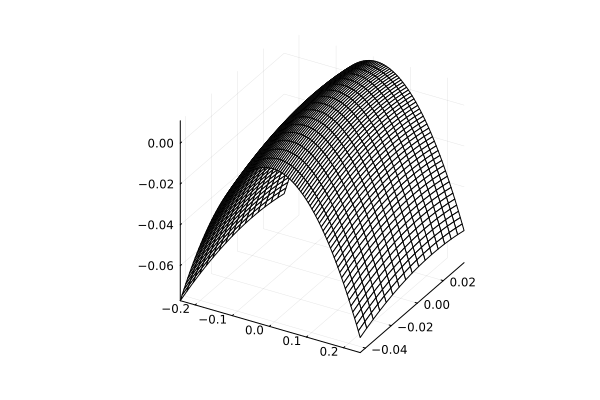

In [21]:
wireframe(
    round(minimum(Z_[1,:]),digits=3):0.005:round(maximum(Z_[1,:]),digits=3),
    round(minimum(Z_[2,:]),digits=3):0.005:round(maximum(Z_[2,:]),digits = 3),
    z3)

┌ Warning: Keyword argument hover not supported with Plots.GRBackend().  Choose from: annotationcolor, annotationfontfamily, annotationfontsize, annotationhalign, annotationrotation, annotations, annotationvalign, arrow, aspect_ratio, axis, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, colorbar_titlefont, colorbar_titlefontcolor, colorbar_titlefontrotation, colorbar_titlefontsize, connections, contour_labels, discrete_values, fill, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, fontfamily, fontfamily_subplot, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, formatter, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefont, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefo

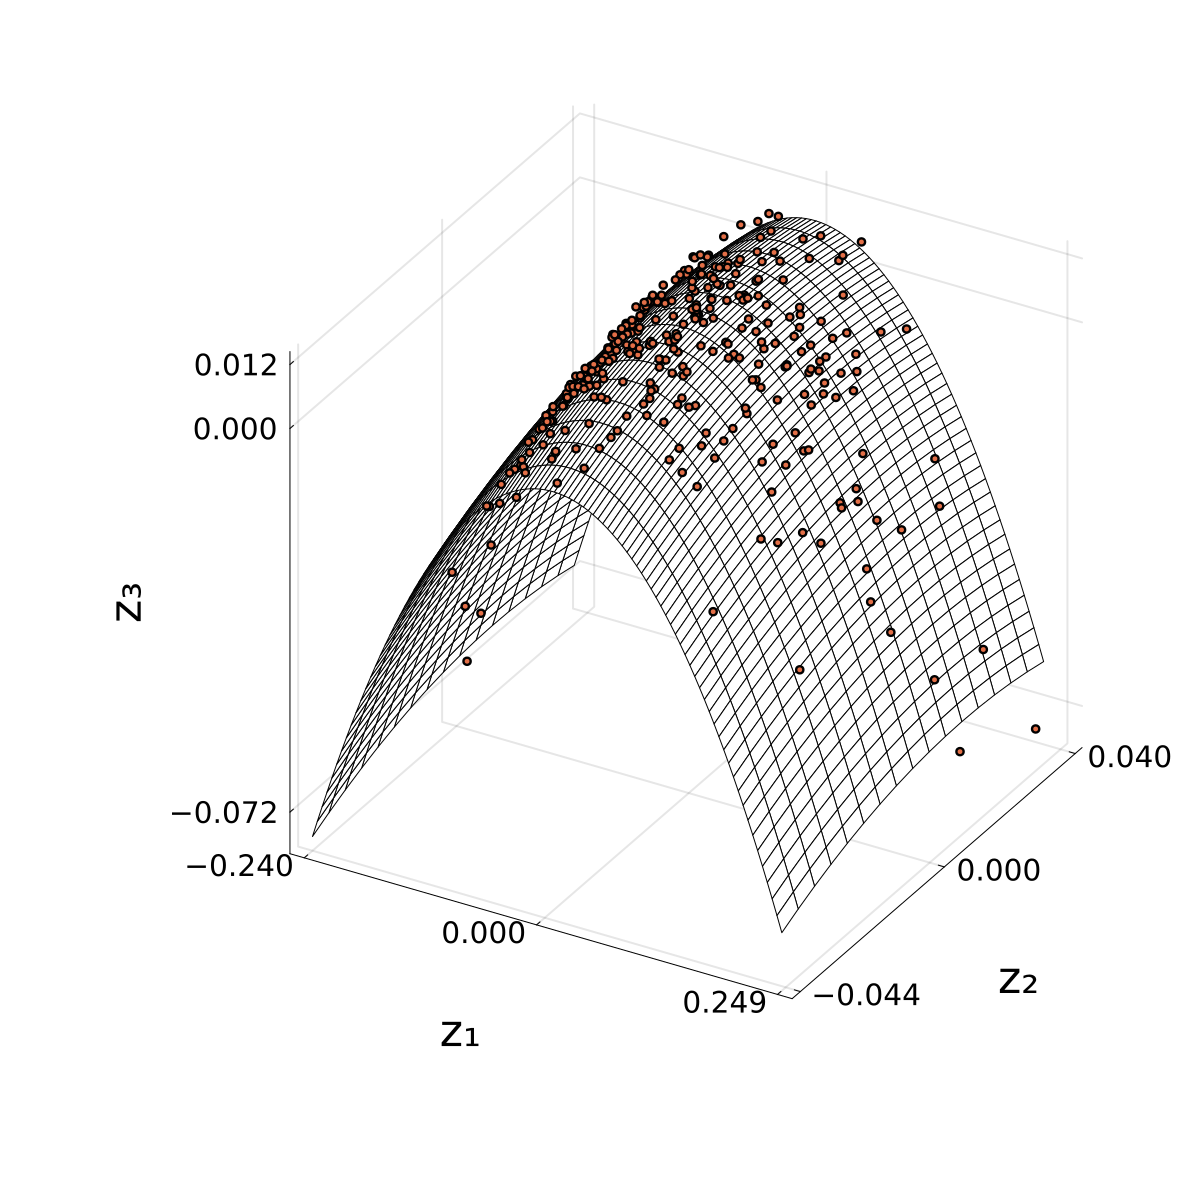

In [22]:
scatter!(eachrow(Z_)...;xlabel="z₁",ylabel="z₂",zlabel="z₃", 
    hover= [i for i in 1:lastindex(eachcol(Z_))],
    # markercolor = [1 for _ in 1:n], #[c[4] for c in conf],
    size=(1200,1200),
    label = false,
    grid = true, gridlinewidth = 2,
    tickfontsize = 20,
    guidefontsize=30,
    zticks=[round(minimum(Z_[3,:]),digits=3),0.0,round(maximum(Z_[3,:]),digits=3)...],
    xticks=[round(minimum(Z_[1,:]),digits=3),0.0,round(maximum(Z_[1,:]),digits=3)...],
    yticks=[round(minimum(Z_[2,:]),digits=3),0.0,round(maximum(Z_[2,:]),digits=3)...],
    markersize = 4
    )

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S_kPCA_5kV.svg")

In [ ]:
# Scatter plot of the TS in RS
scatter(eachrow(Z_)...,xlabel="z1",ylabel="z2",zlabel="z3", 
hover= [i for i in 1:lastindex(eachcol(Z_))])


## Isomap

In [23]:
neighbors = 10
Y_, D_G_sym = isomap1(neighbors,Z_)


100.0 %                         


([0.006000880049018891 -0.0834082502686157 … 0.015099908895943755 -0.1339382172953559; 0.0018998867924304573 0.01375686356285048 … -0.007204164423280673 -0.00808062657464823], [0.0 0.09169942982666351 … 0.013267118128685397 0.14182002595671825; 0.09169942982666351 0.0 … 0.101507950664018 0.05698227709941768; … ; 0.013267118128685397 0.101507950664018 … 0.0 0.14936719873185136; 0.14182002595671825 0.05698227709941768 … 0.14936719873185136 0.0])

In [ ]:
plotlyjs()

In [ ]:
gr()

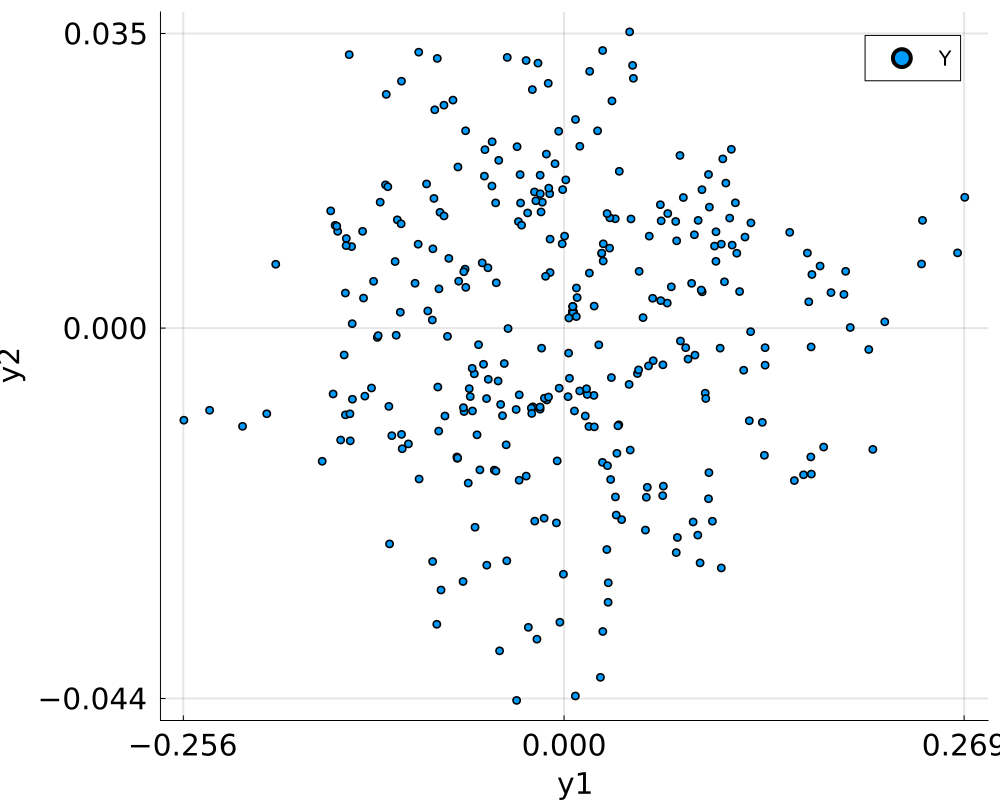

In [24]:
s = scatter(eachrow(Y_)...,xlabel="y1",ylabel="y2",
    # markercolor = [1 for _ in 1:540], #[c[4] for c in conf],
    size=(1000,800),
    # label = false,
    grid = true, gridlinewidth = 2,
    tickfontsize = 20,
    guidefontsize=20,
    legendfontsize=14,
    xticks=[round(minimum(Y_[1,:]),digits=3),0.0,round(maximum(Y_[1,:]),digits=3)...],
    yticks=[round(minimum(Y_[2,:]),digits=3),0.0,round(maximum(Y_[2,:]),digits=3)...],
    markersize = 4,
    label="Y"
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S_isomap_5kV.svg")

In [25]:
VS_list = collect(1:40);

In [ ]:
VectorSearch(Y_,[1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1],VS_list)

In [26]:
Y_gen = []
for conf in eachcol(C_n)
    y_gen = VectorSearch(Y_,conf,VS_list)
    push!(Y_gen,y_gen)
end
Y_gen = reduce(hcat,Y_gen)

2×340 Matrix{Float64}:
 0.00600088  -0.0834083   0.0949034   0.00593082  …   0.0155475   -0.132091
 0.00189989   0.0137569  -0.00772972  0.00199215     -0.00987522  -0.0152462

In [ ]:
Err = norm(Y_gen[41:end]-Y_[41:end])/norm(Y_[41:end])

In [27]:
Err = norm(Y_gen-Y_)/norm(Y_)

0.05842979670820589

In [ ]:
minimum(Y_[1,:])

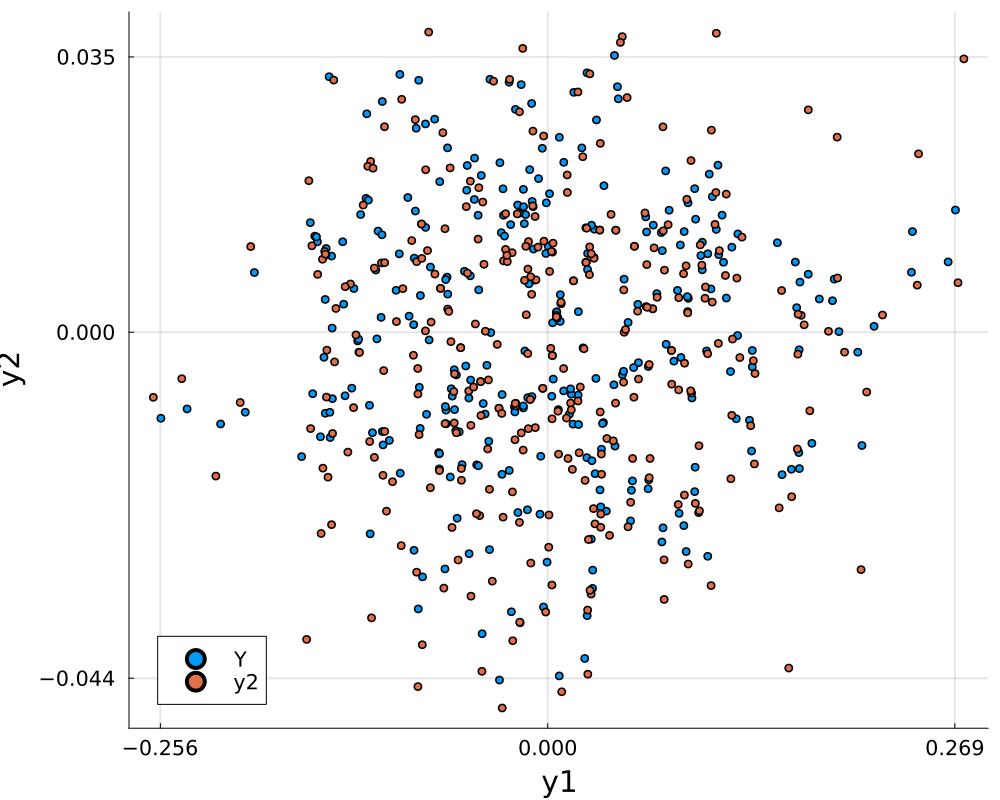

In [28]:
s = scatter!(eachrow(Y_gen)...,xlabel="y1",ylabel="y2",
    # label="Y* (ERR_TS = $(round(Err*100,digits=2))%)",legend=:outerbottom,legend_columns=2,
    size=(1000,800),
    grid = true, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=20,
    xticks=[round(minimum(Y_[1,:]),digits=3),0.0,round(maximum(Y_[1,:]),digits=3)...],
    yticks=[round(minimum(Y_[2,:]),digits=3),0.0,round(maximum(Y_[2,:]),digits=3)...],
    markersize = 4,
)

In [ ]:
function Objective6_(x,x_,X_)
    θ = x[1]
    α = x[2]
    rot = [cos(θ) -sin(θ);sin(θ) cos(θ)]
    scale = [α 0;0 α]
    x_ = rot*x_
    x_ = scale*x_
    return norm(X_-x_)/norm(X_)
end
Objective6(x) = Objective6_(x,Y_gen,Y_)


In [ ]:
x0 = [0.0,1.0]
_min = optimize(Objective6, x0, NelderMead())


In [ ]:
θ = _min.minimizer[1]
(θ/pi)*180

In [ ]:
α = _min.minimizer[2]

In [ ]:
rot = [cos(θ) -sin(θ);sin(θ) cos(θ)]
scale = [α 0;0 α]
Y_gen = rot*Y_gen
Y_gen = scale*Y_gen

In [ ]:
# C_add = C_n[:,1]
C_add = []
X_add = []
Y_add = []
for i in 1:n
    C = C_n[:,i]
    x___ = X[:,i]
    y___ = Y_[:,i]
    n_ = Int(lastindex(C)/2)
    for j in 1:n_
        C_ = copy(C)
        if 1 == bin_to_int4(C[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
            C_[[(((j-1)*2)+1):(((j-1)*2)+2)...]] = [1,1]
            push!(C_add,C_)
            push!(X_add,x___)
            push!(Y_add,y___)
            # hcat(C_add,C_)
        elseif 4 == bin_to_int4(C[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
            C_[[(((j-1)*2)+1):(((j-1)*2)+2)...]] = [0,0]
            push!(C_add,C_)
            push!(X_add,x___)
            push!(Y_add,y___)
            # hcat(C_add,C_)
        end
    end
end
C_add = reduce(hcat,C_add)
X_add = reduce(hcat,X_add)
C_n = hcat(C_n,C_add)
X = hcat(X,X_add)
Y_add = reduce(hcat,Y_add)
Y_ = hcat(Y_,Y_add)

## Optimization of the $\beta$ parameter

In [13]:
function Objective(β)
    println("β = $β")
    VS_list = collect(1:40);
    # Number of principal directions to be considered
    k = 3
    #Gaussian Kernel
    Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    #kPCA
    Λ, U, U_, Ḡ = kPOD(Κ, X, k)
    # Training Set in the reduced space
    Z_ = real.(U_'*Ḡ)
    neighbors = 10
    Y_, D_G_sym = isomap1(neighbors,Z_)
    VS_list = collect(1:40)
    #Generation of full set of parameters in order
    Y_gen = []
    for conf in eachcol(C_n)
        y_gen = VectorSearch(Y_,conf,VS_list)
        push!(Y_gen,y_gen)
    end
    Y_gen = reduce(hcat,Y_gen)
    Err = norm(Y_gen-Y_)/norm(Y_)
    println("Error = $Err")
    println("---------------------")
    return Err
end

Objective (generic function with 1 method)

In [14]:
β_min = optimize(Objective, 0.0, 5.0, GoldenSection(),f_tol=1.0e-6,iterations=50)

β = 1.9098300562505255
100.0 %                         
Error = 0.05979150992952987
---------------------
β = 3.0901699437494736
100.0 %                         
Error = 0.06383729331894643
---------------------
β = 1.1803398874989486
100.0 %                         
Error = 0.059458916315865896
---------------------
β = 0.7294901687515774
100.0 %                         
Error = 0.058578481901126495
---------------------
β = 0.4508497187473713
100.0 %                         
Error = 0.0601423410728223
---------------------
β = 0.9016994374947425
100.0 %                         
Error = 0.05945243797006985
---------------------
β = 0.6230589874905365
100.0 %                         
Error = 0.059570421568408506
---------------------
β = 0.7952682562337016
100.0 %                         
Error = 0.05843964628914109
---------------------
β = 0.8359213500126182
100.0 %                         
Error = 0.059480371762062015
---------------------
β = 0.7701432625304941
100.0 %             

Results of Optimization Algorithm
 * Algorithm: Golden Section Search
 * Search Interval: [0.000000, 5.000000]
 * Minimizer: 8.069924e-01
 * Minimum: 5.842980e-02
 * Iterations: 39
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 40

In [42]:
β_min.minimizer

0.8069923974154574

# ROM Online

## Read Test Data

In [29]:
C_test = CSV.File("data/csv/Config_PB_10S_40ref_1000rand.csv")|> Tables.matrix
C_test = Int.(C_test[:,[1040-29:1040...]])
X_test = x_i.(eachcol(C_test));
X_test = reduce(hcat,X_test)

202×30 Matrix{Float64}:
 0.000396764  0.000300627  0.000400088  …   0.000497109  0.00039993
 0.00039661   0.000307286  0.000400092      0.000490338  0.000399926
 0.00039613   0.000327283  0.000400105      0.000469993  0.000399916
 0.000395262  0.000360676  0.000400128      0.000435965  0.000399897
 0.000393891  0.000407572  0.000400165      0.000388054  0.000399868
 0.000391836  0.00046814   0.00040022   …   0.000325941  0.000399824
 0.000388849  0.000542602  0.000400301      0.000249192  0.000399759
 0.000384569  0.000631284  0.000400417      0.000157172  0.000399665
 0.000378679  0.000734451  0.000400583      4.93131e-5   0.000399531
 0.000369711  0.000853459  0.00040082      -7.67344e-5   0.000399336
 ⋮                                      ⋱                
 0.0866986    0.0907165    0.0919712        0.0922928    0.0896072
 0.0875728    0.0917155    0.0929693        0.0932837    0.0905752
 0.0884469    0.0927156    0.0939675    …   0.0942723    0.0915427
 0.0893212    0.0937167    0

## Surrogate model

In [46]:
n_test = 3
x_test = X_test[:,n_test]


202-element Vector{Float64}:
 0.00040008787211310215
 0.0004000919723780195
 0.0004001047987709198
 0.00040012799997882
 0.00040016467590337325
 0.0004002198490709458
 0.00040030051363375036
 0.000400416695177486
 0.0004005830194604858
 0.00040082027723787743
 ⋮
 0.09197115829097328
 0.09296933591888736
 0.09396750152722398
 0.09496574457006972
 0.09596409711092037
 0.09696255908718468
 0.09796109839589336
 0.09895968824532785
 0.0999582995388234

In [ ]:
c_test = C_test[:,n_test]
y_gen = VectorSearch(Y_,c_test,VS_list)
nh = 4
t = nothing
x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t);


In [47]:
norm(x_gen-x_test)/norm(x_test)

0.19828922372711644

In [ ]:
x_gen

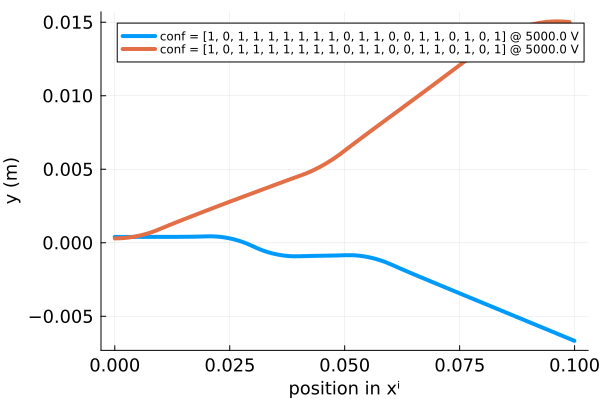

In [48]:
plot([x_test[[102:202...]],x_gen[[102:202...]]],
[x_test[[1:101...]],x_gen[[1:101...]]],
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(c_test) @ $pot V",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
# ylims=(-0.03,0.03)
)

In [ ]:
plot(x_gen,x_gen-x_test)

In [ ]:
nh_ = 20
Err_nh_avg = zeros(nh_)
Threads.@threads for nh in 1:nh_
    Err = []
    for n_test in 1:30
        x_test = X_test[:,n_test]
        c_test = C_test[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        t = nothing
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        push!(Err,norm(x_gen-x_test)/norm(x_test))
    end
    Err_avg = sum(Err)/30
    # push!(Err_nh_avg,Err_avg)
    Err_nh_avg[nh] = Err_avg
end
bar(Err_nh_avg,ylims=(0.0,0.1))

In [ ]:
popfirst!(Err_nh_avg)


In [ ]:
argmin(Err_nh_avg)

In [ ]:
Err = []
for n_test in 1:30
    x_test = X_test[:,n_test]
    c_test = C_test[:,n_test]
    y_gen = VectorSearch(Y_,c_test,VS_list)
    nh = 70
    t = nothing
    x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
    push!(Err,norm(x_gen-x_test)/norm(x_test))
end
bar(Err,label="Error")
Err_avg = sum(Err)/30
plot!(collect(1:30),[Err_avg for _ in 1:30],
linestyle=:dash, linewidth=4, label="Mean Error = $(round(Err_avg,digits=4))",
grid = false, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=14,
    legendfontsize=14,
    yticks=[0.0,round(round(maximum(Err),digits=2)/2,digits=2),round(maximum(Err),digits=2)],
    xticks=[1,10,20,30],
    xlabel="Test configuration"
)

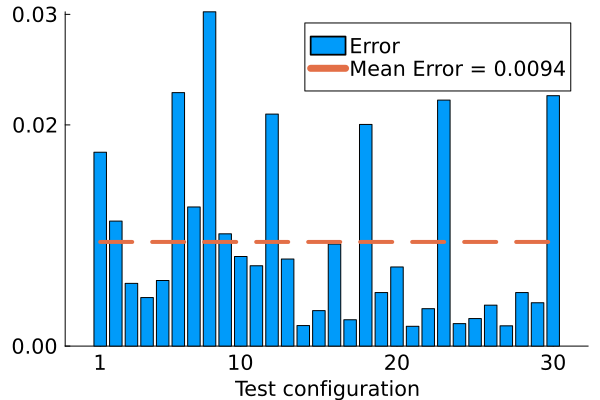

In [56]:
Err = []
for n_test in 1:30
    x_test = X_test[:,n_test]
    c_test = C_test[:,n_test]
    y_gen = VectorSearch(Y_,c_test,VS_list)
    nh = 1
    t = nothing
    x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
    push!(Err,norm(x_gen-x_test)/norm(x_test))
end
bar(Err,label="Error")
Err_avg = sum(Err)/30
plot!(collect(1:30),[Err_avg for _ in 1:30],
linestyle=:dash, linewidth=4, label="Mean Error = $(round(Err_avg,digits=4))",
grid = false, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=14,
    legendfontsize=14,
    yticks=[0.0,round(round(maximum(Err),digits=2)/2,digits=2),round(maximum(Err),digits=2)],
    xticks=[1,10,20,30],
    xlabel="Test configuration"
)

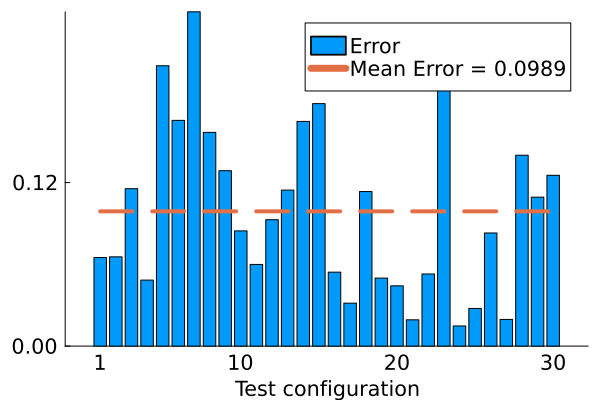

In [58]:
Err = []
for n_test in 1:30
    x_test = X_test[:,n_test]
    c_test = C_test[:,n_test]
    y_gen = VectorSearch(Y_,c_test,VS_list)
    nh = 1
    t = nothing
    x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
    push!(Err,norm(x_gen[[1:101...]]-x_test[[1:101...]])/norm(x_test[[1:101...]]))
end
bar(Err,label="Error")
Err_avg = sum(Err)/30
plot!(collect(1:30),[Err_avg for _ in 1:30],
linestyle=:dash, linewidth=4, label="Mean Error = $(round(Err_avg,digits=4))",
grid = false, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=14,
    legendfontsize=14,
    yticks=[0.0,round(round(maximum(Err),digits=2)/2,digits=2),round(maximum(Err),digits=2)],
    xticks=[1,10,20,30],
    xlabel="Test configuration"
)

In [ ]:
Coeff = []
for n_test in 1:30
    x_test = X_test[:,n_test]
    c_test = C_test[:,n_test]
    y_gen = VectorSearch(Y_,c_test,VS_list)
    nh = 4
    t = nothing
    x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
    Poly2(z) = [1 z]
    A = Poly2.(x_gen)
    A = reduce(vcat,A)
    c = pinv(A)*(x_test)
    push!(Coeff,c)
end


In [ ]:
Coeff = reduce(hcat,Coeff)


In [ ]:
bar(Coeff[2,:])

In [ ]:
sum(Coeff[2,:])/30

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S_5kV_Surrogate_Error_TS_340.svg")

In [ ]:
nh = 1

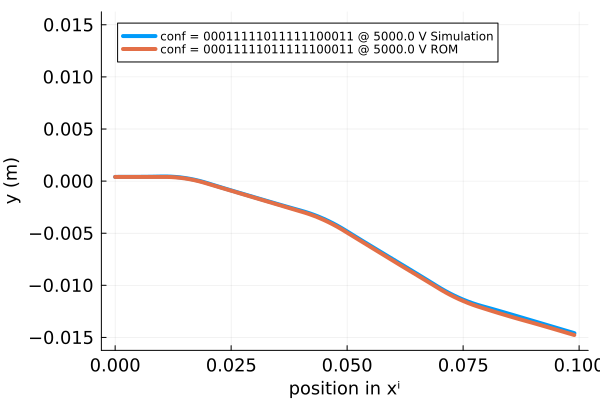

In [59]:
x_i_ = X_test[:,argmin(Err)]
c_test_string = ""
for i in C_test[:,argmin(Err)]
    c_test_string = c_test_string * "$i"
end
plot(x_i_[[102:202...]], x_i_[[1:101...]],
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(c_test_string) @ $pot V Simulation",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
ylims=(-1.1*maximum(abs.(x_i_)),1.1*maximum(abs.(x_i_)))
)
x_i_ = ReverseMap2(VectorSearch(Y_,C_test[:,argmin(Err)],VS_list),C_test[:,argmin(Err)],Y_,X,C_n,nh,nothing)
plot!(x_i_[[102:202...]], x_i_[[1:101...]],
label="conf = $(c_test_string) @ $pot V ROM",
linewidth=4,
ylims=(-1.1*maximum(abs.(x_i_[[1:101...]])),1.1*maximum(abs.(x_i_[[1:101...]])))
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S_5kV_Surrogate_Error_min_$(argmin(Err)).svg")

In [ ]:
argmax(Err)

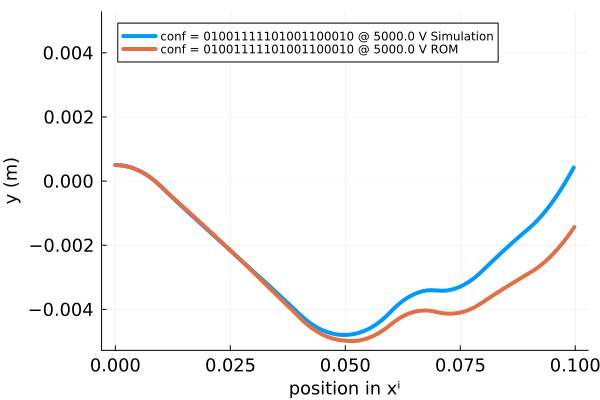

In [60]:
x_i_ = X_test[:,argmax(Err)]
c_test_string = ""
for i in C_test[:,argmax(Err)]
    c_test_string = c_test_string * "$i"
end
plot(x_i_[[102:202...]], x_i_[[1:101...]],
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(c_test_string) @ $pot V Simulation",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
ylims=(-1.1*maximum(abs.(x_i_[[1:101...]])),1.1*maximum(abs.(x_i_[[1:101...]])))
)
x_i_ = ReverseMap2(VectorSearch(Y_,C_test[:,argmax(Err)],VS_list),C_test[:,argmax(Err)],Y_,X,C_n,nh,nothing)
plot!(x_i_[[102:202...]], x_i_[[1:101...]],
label="conf = $(c_test_string) @ $pot V ROM",
linewidth=4,
# ylims=(-1.2*maximum(abs.(x_i_)),1.2*maximum(abs.(x_i_)))
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S_5kV_Surrogate_Error_min_$(argmax(Err)).svg")

In [ ]:
nh = 50
t = nothing
Err = zeros(n)
Threads.@threads for n_test in 1:n
    x_test = X[:,n_test]
    c_test = C_n[:,n_test]
    y_gen = VectorSearch(Y_,c_test,VS_list)
    x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
    Err[n_test] = norm(x_gen-x_test)/norm(x_test)
end
Err_avg_50 = sum(Err)/n

In [ ]:
bar(Err)

In [ ]:
n_ = 100
Err_avg = zeros(n_)
Threads.@threads for nh in 1:n_
    t = nothing
    Err = zeros(n)
    for n_test in 1:n
        x_test = X[:,n_test]
        c_test = C_n[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        Err[n_test] = norm(x_gen-x_test)/norm(x_test)
    end
    Err_avg[nh] = sum(Err)/n
end

In [ ]:
bar(Err_avg,ylims=(0.0,0.5))

In [ ]:
argmin(Err_avg)

In [ ]:
n_ = 10
Err_avg = []
n_list = rand(collect(1:100),n_)
for nh in n_list
    t = nothing
    Err = zeros(n)
    for n_test in 1:n
        x_test = X[:,n_test]
        c_test = C_n[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        Err[n_test] = norm(x_gen-x_test)/norm(x_test)
    end
    push!(Err_avg,sum(Err)/n)
end
nh_min = n_list[armin(Err_avg)]
n_ = 10
Err_avg = []
n_list = collect(nh_min-Int(n_/2)+1:nh_min+Int(n_/2))
for nh in n_list
    t = nothing
    Err = zeros(n)
    for n_test in 1:n
        x_test = X[:,n_test]
        c_test = C_n[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        Err[n_test] = norm(x_gen-x_test)/norm(x_test)
    end
    push!(Err_avg,sum(Err)/n)
end


In [ ]:
nh_min = n_list[argmin(Err_avg)]

## Inverse problem

In [35]:
n_test = 14
x_test = X_test[:,n_test]
c_test = C_test[:,n_test]
y_new = NewData2(x_test,Κ,neighbors,G,Z_,D_G_sym,Y_)

2-element Vector{Float64}:
  0.004730939977307419
 -0.001558323560701163

In [ ]:
scatter!(eachrow(y_new)...)

In [36]:
C_complete = []
for i1 in 0:1, i2 in 0:1, i3 in 0:1, i4 in 0:1, i5 in 0:1, i6 in 0:1, i7 in 0:1, i8 in 0:1, i9 in 0:1, i10 in 0:1, i11 in 0:1, i12 in 0:1, i13 in 0:1, i14 in 0:1, i15 in 0:1, i16 in 0:1, i17 in 0:1, i18 in 0:1, i19 in 0:1, i20 in 0:1
    push!(C_complete,[i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,i11,i12,i13,i14,i15,i16,i17,i18,i19,i20])
end

In [38]:
Y_gen_complete = []
for conf in C_complete
    y_gen = VectorSearch(Y_,conf,VS_list)
    push!(Y_gen_complete,y_gen)
end
Y_gen_complete = reduce(hcat,Y_gen_complete)

2×1048576 Matrix{Float64}:
 0.00600088  0.00624087  0.0057576   …  0.00568061  0.00519735  0.00544274
 0.00189989  0.00195614  0.00191323     0.002432    0.00238909  0.00228727

In [39]:
kdtree = KDTree(Y_gen_complete; leafsize = 10)
idxs, dists = knn(kdtree, y_new, 100, true)
conf_test_i = C_complete[idxs[1]]
c_test == conf_test_i
println(c_test')
println(conf_test_i')

[1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1]
[0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 1]


In [41]:
nh = 1
Err = []
for idx in idxs
    y_gen = VectorSearch(Y_,C_complete[idx],VS_list)
    x_gen = ReverseMap2(y_gen,C_complete[idx],Y_,X,C_n,nh,t)
    push!(Err,norm(x_gen-x_test)/norm(x_test))
end
id = argmin(Err)
conf_test_i = C_complete[idxs[id]]
c_test == conf_test_i
println(c_test')
println(conf_test_i')

[1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1]
[1 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0]


In [ ]:
println(c_test')
println(conf_test_i')

In [ ]:
ph, chache = main(; get_parameters(S, conf_test_i, pot,csv_cl)...)
x_i_ = ReadData_i(S,conf_test_i,pot);

In [ ]:
norm(x_i_-x_test)/norm(x_test)

In [ ]:
plot([x_test,x_i_],
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(c_test) @ $pot V",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
ylims=(-0.03,0.03)
)

In [49]:
Err = []
conf_test_i_list = []
for n_test in 1:30 
    x_test = X_test[:,n_test]
    c_test = C_test[:,n_test]
    y_new = NewData2(x_test,Κ,neighbors,G,Z_,D_G_sym,Y_)
    idxs, dists = knn(kdtree, y_new, 100, true)
    conf_test_i = C_complete[idxs[1]]
    if c_test == conf_test_i
        push!(Err,0.0)
        push!(conf_test_i_list,conf_test_i)
    else
        nh = 6
        Err_ = []
        for idx in idxs
            y_gen = VectorSearch(Y_,C_complete[idx],VS_list)
            x_gen = ReverseMap2(y_gen,C_complete[idx],Y_,X,C_n,nh,t)
            push!(Err_,norm(x_gen-x_test)/norm(x_test))
        end
        id = argmin(Err_)
        conf_test_i = C_complete[idxs[id]]
        if c_test == conf_test_i
            push!(Err,0.0)
            push!(conf_test_i_list,conf_test_i)
        else
            try
                x_i_ = ReadData_i(S,conf_test_i,pot);
            catch
                ph, chache = main(; get_parameters(S, conf_test_i, pot,csv_cl)...)
                x_i_ = ReadData_i(S,conf_test_i,pot);
            end
            push!(Err,norm(x_i_-x_test)/norm(x_test))
            push!(conf_test_i_list,conf_test_i)
        end
    end
end

__________________________________________________________________________________________
|                                                                                         
|                                 MULTISIMO LAB                                           
|                                                                                          
|            Executing MIMOSA Driver for ElectroMechanics Problem                                    
|                                                                                         
|            Problem name PB-S10-O2-/autodiff/Yeoh/PL_1_0_1_1_1_1_1_0_1_1_1_0_1_0_1_1_0_1_1_0_ϕ50000.0                                                          
|                                                                                         
|                                                                                         
|            pname    | PB-S10-O2-/autodiff/Yeoh/PL_1_0_1_1_1_1_1_0_1_1_1_0_1_0_1_1_0_1_1_0_ϕ50000.

Excessive output truncated after 524308 bytes.

In [ ]:
Err = []
conf_test_i_list = []
for n_test in 1:30 
    x_test = X_test[:,n_test]
    c_test = C_test[:,n_test]
    y_new = NewData2(x_test,Κ,neighbors,G,Z_,D_G_sym,Y_)
    idxs, dists = knn(kdtree, y_new, 100, true)
    conf_test_i = C_complete[idxs[1]]
    if c_test == conf_test_i
        push!(Err,0.0)
        push!(conf_test_i_list,conf_test_i)
    else
        nh = 6
        Err_ = []
        for idx in idxs
            y_gen = VectorSearch(Y_,C_complete[idx],VS_list)
            x_gen = ReverseMap2(y_gen,C_complete[idx],Y_,X,C_n,nh,t)
            push!(Err_,norm(x_gen-x_test)/norm(x_test))
        end
        id = argmin(Err_)
        conf_test_i = C_complete[idxs[id]]
        if c_test == conf_test_i
            push!(Err,0.0)
            push!(conf_test_i_list,conf_test_i)
        else
            try
                x_i_ = ReadData_i(S,conf_test_i,pot);
            catch
            end
            push!(Err,norm(x_i_-x_test)/norm(x_test))
            push!(conf_test_i_list,conf_test_i)
        end
    end
end

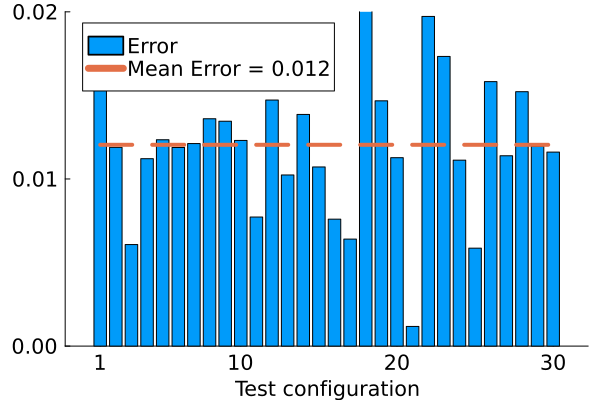

In [50]:
bar(Err,label="Error")
Err_avg = sum(Err)/30
plot!(collect(1:30),[Err_avg for _ in 1:30],
linestyle=:dash, linewidth=4, label="Mean Error = $(round(Err_avg,digits=4))",
grid = false, gridlinewidth = 2,
    tickfontsize = 14,
    guidefontsize=14,
    legendfontsize=14,
    ylims = (0.0,round(maximum(Err),digits=2)),
    yticks=[0.0,round(round(maximum(Err),digits=2)/2,digits=2),round(maximum(Err),digits=2)],
    xticks=[1,10,20,30],
    xlabel="Test configuration"
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S_5kV_Inverse_Error.svg")

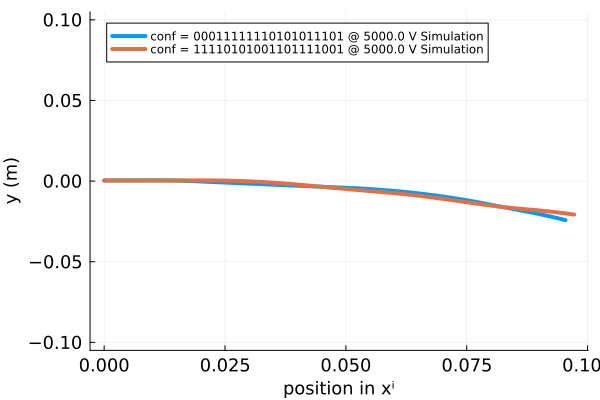

In [53]:
x_i_ = X_test[:,argmax(Err)]
c_test_string = ""
for i in C_test[:,argmax(Err)]
    c_test_string = c_test_string * "$i"
end
plot(x_i_[[102:202...]], x_i_[[1:101...]],
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(c_test_string) @ $pot V Simulation",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
ylims=(-1.1*maximum(abs.(x_i_)),1.1*maximum(abs.(x_i_)))
)
x_i_ = ReadData_i(S,conf_test_i_list[argmax(Err)],pot);
c_test_string = ""
for i in conf_test_i_list[argmax(Err)]
    c_test_string = c_test_string * "$i"
end
plot!(x_i_[[102:202...]], x_i_[[1:101...]],
label="conf = $(c_test_string) @ $pot V Simulation",
linewidth=4,
# ylims=(-1.1*maximum(abs.(x_i_)),1.1*maximum(abs.(x_i_)))
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S_5kV_Inverse_Error_max_$(argmax(Err)).svg")

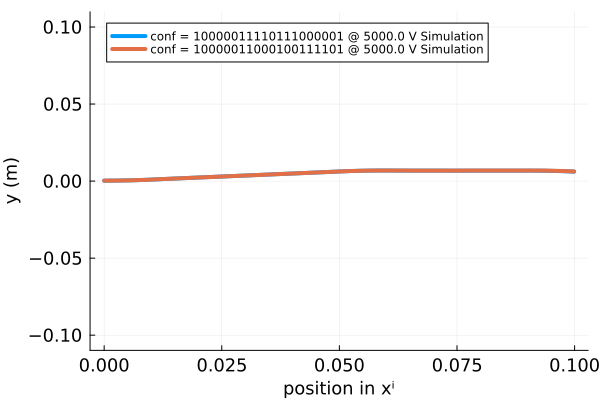

In [54]:
x_i_ = X_test[:,argmin(Err)]
c_test_string = ""
for i in C_test[:,argmin(Err)]
    c_test_string = c_test_string * "$i"
end
plot(x_i_[[102:202...]], x_i_[[1:101...]],
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(c_test_string) @ $pot V Simulation",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
ylims=(-1.1*maximum(abs.(x_i_)),1.1*maximum(abs.(x_i_)))
)
x_i_ = ReadData_i(S,conf_test_i_list[argmin(Err)],pot);
c_test_string = ""
for i in conf_test_i_list[argmin(Err)]
    c_test_string = c_test_string * "$i"
end
plot!(x_i_[[102:202...]], x_i_[[1:101...]],
label="conf = $(c_test_string) @ $pot V Simulation",
linewidth=4,
# ylims=(-1.1*maximum(abs.(x_i_)),1.1*maximum(abs.(x_i_)))
)

In [ ]:
Plots.savefig("G:/My Drive/Temp/Comunication/ROM_Paper/PB10S_5kV_Inverse_Error_min_$(argmin(Err)).svg")

## TS test

In [ ]:
Err_TS_list = []
Err_avg_1_list = []
Err_avg_3_list = []
Err_avg_5_list = []
Err_avg_7_list = []
Err_avg_9_list = []
Err_avg_11_list = []
Err_avg_13_list = []
n_list = collect(340:25:1040)
for i in 1:lastindex(n_list)
    n = n_list[i]
    println("-------------------")
    println("n = $n")
    C_n = CSV.File("data/csv/Config_PB_10S_40ref_1000rand.csv")|> Tables.matrix
    C_n = Int.(C_n[:,[1:n...]])
    X = x_i.(eachcol(C_n));
    X = reduce(hcat,X)
    # Number of principal directions to be considered
    k = 3
    #Gaussian Kernel
    β = 0.8069923974154574 # 0.7799182206818172
    Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
    Λ, U, U_, Ḡ, G = kPOD(Κ, X, k)
    Z_ = real.(U_'*Ḡ)
    neighbors = 10
    Y_, D_G_sym = isomap1(neighbors,Z_)
    VS_list = collect(1:40)
    Y_gen = []
    for conf in eachcol(C_n)
        y_gen = VectorSearch(Y_,conf,VS_list)
        push!(Y_gen,y_gen)
    end
    Y_gen = reduce(hcat,Y_gen)
    Err = norm(Y_gen-Y_)/norm(Y_)
    push!(Err_TS_list,Err)
    println("Errot_TS = $Err")
    # C_add = C_n[:,1]
    # C_add = []
    # X_add = []
    # Y_add = []
    # for i in 1:n
    #     C = C_n[:,i]
    #     x___ = X[:,i]
    #     y___ = Y_[:,i]
    #     n_ = Int(lastindex(C)/2)
    #     for j in 1:n_
    #         C_ = copy(C)
    #         if 1 == bin_to_int4(C[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
    #             C_[[(((j-1)*2)+1):(((j-1)*2)+2)...]] = [1,1]
    #             push!(C_add,C_)
    #             push!(X_add,x___)
    #             push!(Y_add,y___)
    #             # hcat(C_add,C_)
    #         elseif 4 == bin_to_int4(C[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
    #             C_[[(((j-1)*2)+1):(((j-1)*2)+2)...]] = [0,0]
    #             push!(C_add,C_)
    #             push!(X_add,x___)
    #             push!(Y_add,y___)
    #             # hcat(C_add,C_)
    #         end
    #     end
    # end
    # C_add = reduce(hcat,C_add)
    # X_add = reduce(hcat,X_add)
    # C_n = hcat(C_n,C_add)
    # X = hcat(X,X_add)
    # Y_add = reduce(hcat,Y_add)
    # Y_ = hcat(Y_,Y_add)
    nh = 1
    t = nothing
    Err = []
    for n_test in 1:30
        x_test = X_test[:,n_test]
        c_test = C_test[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        push!(Err,norm(x_gen-x_test)/norm(x_test))
    end
    Err_avg_1 = sum(Err)/30
    push!(Err_avg_1_list,Err_avg_1)
    println("Err_avg = $Err_avg_1")
    nh = 3
    t = nothing
    Err = []
    for n_test in 1:30
        x_test = X_test[:,n_test]
        c_test = C_test[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        push!(Err,norm(x_gen-x_test)/norm(x_test))
    end
    Err_avg_3 = sum(Err)/30
    println("Err_avg = $Err_avg_3")
    push!(Err_avg_3_list,Err_avg_3)
    nh = 5
    t = nothing
    Err = []
    for n_test in 1:30
        x_test = X_test[:,n_test]
        c_test = C_test[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        push!(Err,norm(x_gen-x_test)/norm(x_test))
    end
    Err_avg_5 = sum(Err)/30
    println("Err_avg = $Err_avg_5")
    push!(Err_avg_5_list,Err_avg_5)
    nh = 7
    t = nothing
    Err = []
    for n_test in 1:30
        x_test = X_test[:,n_test]
        c_test = C_test[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        push!(Err,norm(x_gen-x_test)/norm(x_test))
    end
    Err_avg_7 = sum(Err)/30
    println("Err_avg = $Err_avg_7")
    push!(Err_avg_7_list,Err_avg_7)
    nh = 9
    t = nothing
    Err = []
    for n_test in 1:30
        x_test = X_test[:,n_test]
        c_test = C_test[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        push!(Err,norm(x_gen-x_test)/norm(x_test))
    end
    Err_avg_9 = sum(Err)/30
    println("Err_avg = $Err_avg_9")
    push!(Err_avg_9_list,Err_avg_9)
    nh = 11
    t = nothing
    Err = []
    for n_test in 1:30
        x_test = X_test[:,n_test]
        c_test = C_test[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        push!(Err,norm(x_gen-x_test)/norm(x_test))
    end
    Err_avg_11 = sum(Err)/30
    println("Err_avg = $Err_avg_11")
    push!(Err_avg_11_list,Err_avg_11)
    nh = 13
    t = nothing
    Err = []
    for n_test in 1:30
        x_test = X_test[:,n_test]
        c_test = C_test[:,n_test]
        y_gen = VectorSearch(Y_,c_test,VS_list)
        x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
        push!(Err,norm(x_gen-x_test)/norm(x_test))
    end
    Err_avg_13 = sum(Err)/30
    println("Err_avg = $Err_avg_13")
    push!(Err_avg_13_list,Err_avg_13)
    println("-------------------")
    
end

-------------------
n = 340
100.0 %                         
Errot_TS = 0.05842979670820589
Err_avg = 0.00941559331505614
Err_avg = 0.05043181083656518
Err_avg = 0.030599734152182333
Err_avg = 0.05866206315808525
-------------------
Err_avg = 0.013979214393173655
-------------------
Err_avg = 0.011878941222347799
-------------------
Err_avg = 0.013195807210261642
-------------------
-------------------
n = 365
100.0 %                         
Errot_TS = 0.056568871281011956
Err_avg = 0.010204443785311577
Err_avg = 0.020223659430611236
Err_avg = 0.018089088182349708
Err_avg = 0.013578057406678485
-------------------
Err_avg = 0.015333345954177298
-------------------
Err_avg = 0.013528828271879654
-------------------
Err_avg = 0.010963276265938082
-------------------
-------------------
n = 390
100.0 %                         
Errot_TS = 0.05591485410476233
Err_avg = 0.009160201495660785
Err_avg = 0.03859815640603749
Err_avg = 0.017411430145938923
Err_avg = 0.01848236905837424
----------

In [ ]:
Err_TS_list

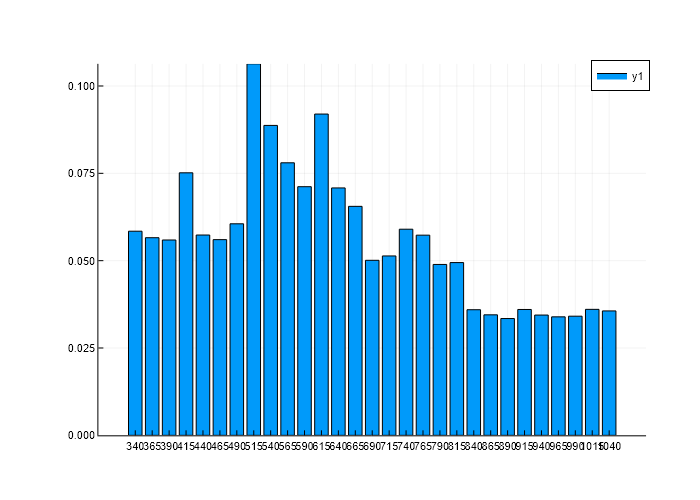

In [25]:
bar(n_list,Err_TS_list,xticks=n_list)

In [ ]:
Err_avg_list[10]=0.0

In [ ]:
Err_avg_list

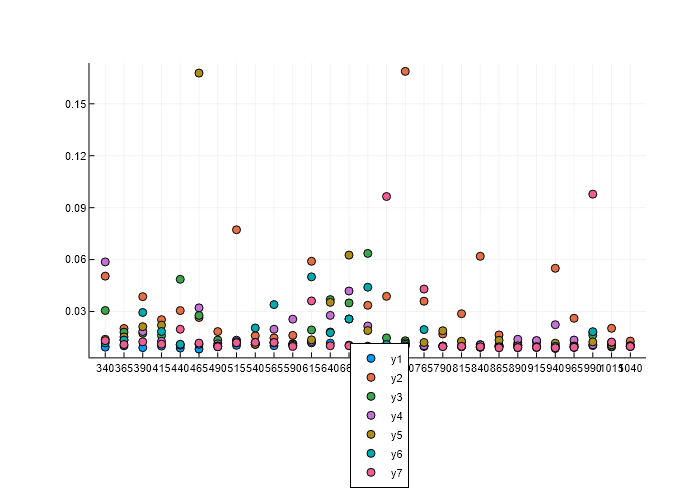

In [24]:
scatter(n_list,[Err_avg_1_list,Err_avg_3_list,Err_avg_5_list,Err_avg_7_list,Err_avg_9_list,Err_avg_11_list,Err_avg_13_list],
xticks=n_list,
# ylims=(0.0,0.015),
legendposition=:outerbottom)

In [ ]:
n_list = collect(90:50:540)
n = n_list[7]
C_n = CSV.File("data/csv/Config_PB_10S_40ref_1000rand.csv")|> Tables.matrix
C_n = Int.(C_n[:,[1:n...]])
X = x_i.(eachcol(C_n));
X = reduce(hcat,X)
# Number of principal directions to be considered
k = 3
#Gaussian Kernel
β = 0.7799182206818172
Κ(X1,X2) = exp(-β*(dot(X1-X2,X1-X2)))
Λ, U, U_, Ḡ, G = kPOD(Κ, X, k)
Z_ = real.(U_'*Ḡ)
neighbors = 20
Y_, D_G_sym = isomap1(neighbors,Z_)
C_add = []
X_add = []
Y_add = []
for i in 1:n
    C = C_n[:,i]
    x___ = X[:,i]
    y___ = Y_[:,i]
    n_ = Int(lastindex(C)/2)
    for j in 1:n_
        C_ = copy(C)
        if 1 == bin_to_int4(C[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
            C_[[(((j-1)*2)+1):(((j-1)*2)+2)...]] = [1,1]
            push!(C_add,C_)
            push!(X_add,x___)
            push!(Y_add,y___)
            # hcat(C_add,C_)
        elseif 4 == bin_to_int4(C[[(((j-1)*2)+1):(((j-1)*2)+2)...]])
            C_[[(((j-1)*2)+1):(((j-1)*2)+2)...]] = [0,0]
            push!(C_add,C_)
            push!(X_add,x___)
            push!(Y_add,y___)
            # hcat(C_add,C_)
        end
    end
end
C_add = reduce(hcat,C_add)
X_add = reduce(hcat,X_add)
C_n = hcat(C_n,C_add)
X = hcat(X,X_add)
Y_add = reduce(hcat,Y_add)
Y_ = hcat(Y_,Y_add)
Y_gen = []
for conf in eachcol(C_n)
    y_gen = VectorSearch(Y_,conf,VS_list)
    push!(Y_gen,y_gen)
end
Y_gen = reduce(hcat,Y_gen)
Err = norm(Y_gen-Y_)/norm(Y_)
push!(Err_TS_list,Err)
println("Errot_TS = $Err")
n_test = 5
x_test = X_test[:,n_test]
c_test = C_test[:,n_test]
y_gen = VectorSearch(Y_,c_test,VS_list)
nh = 3
t = nothing
x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t);
Err = []
for n_test in 1:30
    x_test = X_test[:,n_test]
    c_test = C_test[:,n_test]
    y_gen = VectorSearch(Y_,c_test,VS_list)
    x_gen = ReverseMap2(y_gen,c_test,Y_,X,C_n,nh,t)
    push!(Err,norm(x_gen-x_test)/norm(x_test))
end
Err_avg = sum(Err)/30

In [ ]:
argmax(Err)

In [ ]:
x_i_ = X_test[:,argmax(Err)]
c_test_string = ""
for i in C_test[:,argmax(Err)]
    c_test_string = c_test_string * "$i"
end
plot(x_i_,
xlabel ="position in xⁱ",
ylabel = "y (m)",
linewidth=4,
label="conf = $(c_test_string) @ $pot V Simulation",
legendfontsize=8,
guidefontsize=12,
tickfontsize=12,
legend=:topleft,
ylims=(-1.1*maximum(abs.(x_i_)),1.1*maximum(abs.(x_i_)))
)
x_i_ = ReverseMap2(VectorSearch(Y_,C_test[:,argmax(Err)],VS_list),C_test[:,argmax(Err)],Y_,X,C_n,nh,nothing)
plot!(x_i_,
label="conf = $(c_test_string) @ $pot V ROM",
linewidth=4,
ylims=(-1.2*maximum(abs.(x_i_)),1.2*maximum(abs.(x_i_)))
)